In [1]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import QuantileTransformer

We discussed the loading and cleaning process in detail in the LoadingIndia notebook, where the Decadal Population Variation and Work files for India were loaded going through the steps one by one. However, since ultimately I want to put individual districts in clusters, I actually need to work on the Individual State files - I'll do that here. I'll circle through all those files (except the India ones) - load them, clean them and keep on joining them with the target of  having the whole information available in a single dataset at the end.

Please refer to the LoadingIndia notebook for more details on why I took individual measures while loading the files - since each step was already discussed in detail there, I’m not going to delve deep on those here.

### Cleaning Functions to be Used for File Loading

In [2]:
# Population Dataframe
def clean_numerical_strings(str_frm_df: str) -> str:
    '''
        this function will be used to clean year, state/district codes
        the input from the dataframe can be a string with or without extra characters, or
        it can be a clean int the output should always be cleaned string
        with numerical characters forming int
    '''
    str_frm_df_int = re.sub(r'\.0+$', '', str(str_frm_df))
    # removing .0 added due to data being treated as float
    cleaned_str = ''.join([character for character in str(str_frm_df_int)\
                           if character.isdigit()])
    return str(cleaned_str)

def year2censusyear(year_frm_df_str: int) -> int:
    '''
        the input Year from the dataframe can be any year around the census years
        (1901, 1911, ..., 2001, 2011), like 1912, 2010 etc.
        the output should be the corresponding census year
    '''
    year_frm_df = int(year_frm_df_str)
    remainder = year_frm_df % 10
    if remainder == 1:
        return year_frm_df
    else:
        quotient = year_frm_df // 10
        # (quotient * 10 + 1) is previous census year
        # ((quotient + 1) * 10 + 1) is next census year
        if ((year_frm_df - (quotient * 10 + 1)) > (((quotient + 1) * 10 + 1) - year_frm_df)):
            return ((quotient + 1) * 10 + 1) # return next census year if that is closer
        else:
            return (quotient * 10 + 1) # return previous census year otherwise

def clean_Names(name_frm_df: str) -> str:
    '''
        the input Name may contain some extra spaces and extra non-alphabet characters
        output should be cleaned of all that (including spaces between words)
        and be in all upper case
    '''
    cleaned_name = ''.join([character.upper() for character in name_frm_df\
                            if character.isalpha()])
    return cleaned_name

def clean_number(num_str : str) -> float:
    '''
        input can be str or int or float, need to be able to handle all 3.
        The ones with comma or extra space are str - those need to be cleaned before
        returning the int/float value (signed or unsigned) corresponding to the
        input string or null otherwise. the regex match returns None if it's not a match.
    '''
    if (type(num_str) == str):
        num_str = num_str.replace(' ', '')
        num_str = num_str.replace(',', '')
        
    if ('.' in str(num_str)): # if input contains dot(.), i.e., input could be float
        if (re.match(r'[-+]?\d+\.\d+$', str(num_str)) is None): # doesn't match float pattern
            return np.nan
        elif (float(num_str) == 0): # return null for 0
            return np.nan
        else:
            return float(num_str)
    else:                    # input does not contain dot(.), i.e., input could be int
        if (re.match(r'[-+]?\d+$', str(num_str)) is None): # doesn't match int pattern
            return np.nan
        elif(int(num_str) == 0): # return null for 0
            return np.nan
        else:
            return int(num_str)
    
def validate_number(num_str : str) -> bool :
    '''
        input can be str or int or float, need to be able to handle all 3.
        The ones with comma or extra space are str - those need to be cleaned before
        validating whether the remining characters form a float/int (signed or unsigned).
        the regex match returns None if it's not a match.
    '''
    if(type(num_str) == str):
        num_str = num_str.replace(' ', '')
        num_str = num_str.replace(',', '')
    if ('.' in str(num_str)): # if input contains dot(.), i.e., input could be float
        return (re.match(r'[-+]?\d+\.\d+$', str(num_str)) is not None)
    else:                     # input does not contain dot(.), i.e., input could be int
        return (re.match(r'[-+]?\d+$', str(num_str)) is not None)

# Work Dataframe
def clean_Names_work(name_frm_work_df: str) -> str:
    '''
        the input Names in work dataframe are typically  in this format
        (with spaces, except 'INDIA'):
        <type of name (State/UT/District etc.)><hyphen(-)><Name>
        <Statecode or district serial (not district code) in parantheses>
        like - "State - LAKSHADWEEP (31)"
        I just need the name (in all upper case)
        output should be cleaned of all else (including spaces between words)
    '''
    if '-' in name_frm_work_df:
        name_str = ''.join(name_frm_work_df.split('-')[1:])
    else:
        name_str = name_frm_work_df
    cleaned_name = ''.join([character.upper() for character in name_str\
                            if character.isalpha()])
    return cleaned_name

def validate_int_work(int_str: str) -> bool :
    '''
        input can be str or int, I am assuming that they are int
        I'll validate whether the string is actually an int (signed or unsigned),
        it will return True if that is the case, False otherwise (not an int).
        the regex match returns None if it's not a match.
    '''
    return (re.match('[-+]?\d+$', str(int_str)) is not None)

### Loading Decadal Population Variation Files

In [3]:
df_master_pop = pd.DataFrame()

# Population File
filepath_pop = 'PopVarFiles/'
for path, _, files in os.walk(filepath_pop):
    for file in files:
        
        
        if ('India' in str(file)): # only dealing with State files here
            continue
        print('Loading {}.'.format(file))
        
        
        # had to add usecols to resolve issue with Nagaland and others, where the whole
        # dataset was getting loaded in the index and actual dataframe was just
        # nulls with provided column names
        df_state_pop = pd.read_excel(os.path.join(path, file),
                                     usecols = [0, 1, 2, 3, 4, 5, 6, 7, 8],
                                     names = ['State Code', 'District Code', 'Name', 'Year',\
                                              'Population', 'Abs_var_since_last',\
                                              'Pct_var_since_last', 'Males', 'Females'])
        # tab_start_idx = min([i for i in df_state_pop.index\
        #  if ((df_state_pop.iloc[i, 3] == 1901) |\
        # ('1901' in str(df_state_pop.iloc[i, 3])))])
        # Logic for tab_start_idx, tab_end_idx changed to handle 1st census year
        # of 1900 for Daman & DIU
        tab_start_idx = min([i for i in df_state_pop.index\
                             if ((df_state_pop.iloc[i, 3] == 1901) |\
                                 ('190' in str(df_state_pop.iloc[i, 3])))])
        tab_end_idx = max([i for i in df_state_pop.index\
                           if ((df_state_pop.iloc[i, 3] == 2011) |\
                               ('201' in str(df_state_pop.iloc[i, 3])))])
        df_state_pop = df_state_pop.iloc[tab_start_idx : (tab_end_idx + 1)]
        
        
        # replacing whitespace entries with null
        df_state_pop.replace(r'^\s*$', np.nan, regex = True, inplace = True)
        
        
        # Nulls
        all_null_rowcount = df_state_pop.isna().all(axis = 1).sum()
        before_drop_rowcount = len(df_state_pop)
        df_state_pop.dropna(axis = 0, how = 'all', inplace = True)
        after_drop_rowcount = len(df_state_pop)
        assert before_drop_rowcount == all_null_rowcount + after_drop_rowcount
        print('{} rows reduced to {} rows after dropping {} All Null rows.'\
              .format(before_drop_rowcount, after_drop_rowcount, all_null_rowcount))
        # State Code, District Code, Name - each of them only have information
        # in the first year row (1901 mostly), and it's implied that the following
        # years (1911, 1921 etc.) are for the same state/district until
        # a new state or district is mentioned for the next 1901 entry.
        df_state_pop[['State Code', 'District Code', 'Name']] =\
            df_state_pop[['State Code', 'District Code', 'Name']].fillna(method = 'ffill')
        df_state_pop.reset_index(drop = True, inplace = True)
        
        
        # cleaning state code, district code, year as int-like str and
        # State/Union Territory/District etc. (Name)
        df_state_pop['State Code'] = \
                               df_state_pop['State Code'].apply(clean_numerical_strings)
        df_state_pop['District Code'] =\
                               df_state_pop['District Code'].apply(clean_numerical_strings)
        df_state_pop['Year'] = df_state_pop.Year.apply(clean_numerical_strings)
        df_state_pop['Year'] = df_state_pop.Year.apply(year2censusyear)
        df_state_pop['Name'] = df_state_pop.Name.apply(clean_Names)
        
        
        # validating & cleaning numbers
        val_Population = df_state_pop.Population.apply(validate_number)
        val_Abs_var_since_last = df_state_pop.Abs_var_since_last.apply(validate_number)
        val_Pct_var_since_last = df_state_pop.Pct_var_since_last.apply(validate_number)
        val_Males = df_state_pop.Males.apply(validate_number)
        val_Females = df_state_pop.Females.apply(validate_number)
        num_fmt_mismatch_count = (~(val_Population & val_Abs_var_since_last & val_Males &\
                                    val_Females & val_Pct_var_since_last)).sum()
        row_count_1901 = ((~(val_Population & val_Abs_var_since_last & val_Males &\
                             val_Females & val_Pct_var_since_last))\
                          & (df_state_pop.Year == 1901)).sum()
        # 1901 rows contain atleast 2 null values for Abs_var_since_last & Pct_var_since_last
        # so, suppressing those rows from being displayed
        if ((num_fmt_mismatch_count > 0) & (num_fmt_mismatch_count > row_count_1901)):
            print('Numerical format mismatch in {} records, will be replaced with null.'
                  ' {} rows for 1901 are hidden.'\
                  .format(num_fmt_mismatch_count, row_count_1901))
            print(df_state_pop[(~(val_Population & val_Abs_var_since_last & val_Males &\
                                  val_Females & val_Pct_var_since_last))\
                               & (df_state_pop.Year != 1901)])
        elif ((num_fmt_mismatch_count > 0) & (num_fmt_mismatch_count == row_count_1901)):
            print('Missing relative (since_last) change numbers in {} first census year '
                  '(1901) records, will be replaced with null.'.format(row_count_1901))
        df_state_pop['Population'] = df_state_pop.Population.apply(clean_number)
        df_state_pop['Abs_var_since_last'] = df_state_pop.Abs_var_since_last.\
                                                            apply(clean_number)
        df_state_pop['Males'] = df_state_pop.Males.apply(clean_number)
        df_state_pop['Females'] = df_state_pop.Females.apply(clean_number)
        df_state_pop['Pct_var_since_last'] = df_state_pop.Pct_var_since_last.\
                                                            apply(clean_number)
        
        
        # Female population as a percentage of total population
        if ((df_state_pop.Population -\
             (df_state_pop.Males + df_state_pop.Females)).sum() != 0):
            print('Mismatch Between Total Population and Number of Males & Females :')
            print(df_state_pop[df_state_pop.Population !=\
                               (df_state_pop.Males + df_state_pop.Females)])
        df_state_pop['Female_pct'] = (df_state_pop.Females * 100)/\
                                    (df_state_pop.Males + df_state_pop.Females)
        
        
        df_state_pop.drop(['Population', 'Abs_var_since_last', 'Males', 'Females'],
                          axis = 1,
                          inplace = True)
        df_master_pop = pd.concat([df_master_pop, df_state_pop], ignore_index = True)
        print('{} data merged with master dataset.'.format(file))

Loading AndamanandNicobarIslands.xlsx.
51 rows reduced to 48 rows after dropping 3 All Null rows.
Missing relative (since_last) change numbers in 4 first census year (1901) records, will be replaced with null.
AndamanandNicobarIslands.xlsx data merged with master dataset.
Loading AndhraPradesh.xlsx.
311 rows reduced to 288 rows after dropping 23 All Null rows.
Missing relative (since_last) change numbers in 24 first census year (1901) records, will be replaced with null.
AndhraPradesh.xlsx data merged with master dataset.
Loading ArunachalPradesh.xlsx.
220 rows reduced to 204 rows after dropping 16 All Null rows.
Numerical format mismatch in 119 records, will be replaced with null. 17 rows for 1901 are hidden.
    State Code District Code              Name  Year Population  \
1           12           000  ARUNACHALPRADESH  1911        N.A   
2           12           000  ARUNACHALPRADESH  1921        N.A   
3           12           000  ARUNACHALPRADESH  1931        N.A   
4           

25 rows reduced to 24 rows after dropping 1 All Null rows.
Missing relative (since_last) change numbers in 2 first census year (1901) records, will be replaced with null.
Dadra&NagarHaveli.xlsx data merged with master dataset.
Loading Daman&Diu.xlsx.
38 rows reduced to 36 rows after dropping 2 All Null rows.
Missing relative (since_last) change numbers in 3 first census year (1901) records, will be replaced with null.
Daman&Diu.xlsx data merged with master dataset.
Loading Goa.xls.
38 rows reduced to 36 rows after dropping 2 All Null rows.
Missing relative (since_last) change numbers in 3 first census year (1901) records, will be replaced with null.
Goa.xls data merged with master dataset.
Loading Gujarat.xlsx.
350 rows reduced to 324 rows after dropping 26 All Null rows.
Missing relative (since_last) change numbers in 27 first census year (1901) records, will be replaced with null.
Gujarat.xlsx data merged with master dataset.
Loading Haryana.xls.
286 rows reduced to 264 rows after dr

129 rows reduced to 120 rows after dropping 9 All Null rows.
Numerical format mismatch in 64 records, will be replaced with null. 10 rows for 1901 are hidden.
    State Code District Code       Name  Year       Population  \
13          07           090  NORTHWEST  1911             N.A.   
14          07           090  NORTHWEST  1921             N.A.   
15          07           090  NORTHWEST  1931             N.A.   
16          07           090  NORTHWEST  1941             N.A.   
17          07           090  NORTHWEST  1951             N.A.   
18          07           090  NORTHWEST  1961           240973   
25          07           091      NORTH  1911             N.A.   
26          07           091      NORTH  1921             N.A.   
27          07           091      NORTH  1931             N.A.   
28          07           091      NORTH  1941             N.A.   
29          07           091      NORTH  1951             N.A.   
30          07           091      NORTH  1961    

444 rows reduced to 408 rows after dropping 36 All Null rows.
Missing relative (since_last) change numbers in 34 first census year (1901) records, will be replaced with null.
Rajasthan.xlsx data merged with master dataset.
Loading Sikkim.xlsx.
64 rows reduced to 60 rows after dropping 4 All Null rows.
Numerical format mismatch in 31 records, will be replaced with null. 5 rows for 1901 are hidden.
   State Code District Code           Name  Year     Population  \
13         11           241  NORTHDISTRICT  1911           N.A.   
14         11           241  NORTHDISTRICT  1921           N.A.   
15         11           241  NORTHDISTRICT  1931           N.A.   
16         11           241  NORTHDISTRICT  1941           N.A.   
17         11           241  NORTHDISTRICT  1951           N.A.   
18         11           241  NORTHDISTRICT  1961           9759   
25         11           242   WESTDISTRICT  1911           N.A.   
26         11           242   WESTDISTRICT  1921           N.A. 

### Loading Work Files (General Economic Tables showing breakdown of Main Workers, Marginal Workers & Non-Workers by Age & Sex (PC11-B01))

Brief information about table columns (taken from https://censusindia.gov.in/nada/index.php/catalog/12602, first 3 columns are not mentioned below - Table Code, State Code, District Code):
- *Area name*
- *Residence* - Total, Rural, Urban (Same column, separate rows)
- *Age group* - Total, 5-9, 10-14, 15-19, 20-24, 25-29, 30-34, 35-39, 40-49, 50-59, 60-69, 70-79, 80+, Age not stated, 15-59, 60+ (Same column, separate rows)
- *Population* - Person, Male, Female (Separate columns)
- *Main workers* - Person, Male, Female (Separate columns)
- Marginal workers - Worked for less than 3 months - Total - Person, Male, Female (Separate columns)
- Marginal workers - Worked for 3 to 6 months - Total - Person, Male, Female (Separate columns)
- Marginal workers - Seeking / available for work - Person, Male, Female (Separate columns)
- Non workers - Total - Person, Male, Female (Separate columns)
- Non workers - Seeking / available for work - Person, Male, Female (Separate columns)

Columns highlighted in *italics* are the ones I kept.

In [4]:
# Work File
df_master_work = pd.DataFrame()

filepath_work = 'WorkFiles/'
for path, _, files in os.walk(filepath_work):
    for file in files:
        
        
        if ('India' in str(file)):
            continue
        print('Loading {}.'.format(file))
        
        
        df_state_work = pd.read_excel(os.path.join(path, file),
                                      names = ['Table Name', 'State Code', 'District Code',\
                                               'Name', 'Area', 'Age-Group', 'Pop-Persons',\
                                               'Pop-Males', 'Pop-Females', 'Main-Persons',\
                                               'Main-Males', 'Main-Females',\
                                               'Marg-lt3mo-Persons', 'Marg-lt3mo-Males',\
                                               'Marg-lt3mo-Females', 'Marg-3to6mo-Persons',\
                                               'Marg-3to6mo-Males', 'Marg-3to6mo-Females',\
                                               'Marg-sw-Persons', 'Marg-sw-Males',\
                                               'Marg-sw-Females', 'NW-Persons', 'NW-Males',\
                                               'NW-Females', 'NW-sw-Persons', 'NW-sw-Males',\
                                               'NW-sw-Females'])
        
        
        # table start = 1st Area (Residence) = Total & Age-Group = Total
        # table end = last Area (Residence) = Urban & Age-Group = 60+
        tab_start_idx = min([i for i in df_state_work.index\
                                                 if ((df_state_work.iloc[i, 4] == 'Total') &\
                                                    (df_state_work.iloc[i, 5] == 'Total'))])
        tab_end_idx = max([i for i in df_state_work.index\
                                                if ((df_state_work.iloc[i, 4] == 'Urban') &\
                                                    (df_state_work.iloc[i, 5] == '60+'))])
        df_state_work = df_state_work.iloc[tab_start_idx : (tab_end_idx + 1)]
        df_state_work.reset_index(drop = True, inplace = True)
        
        
        df_state_work = df_state_work[['State Code', 'District Code', 'Name', 'Area',\
                                       'Age-Group', 'Pop-Persons', 'Pop-Males',\
                                       'Pop-Females', 'Main-Persons', 'Main-Males',\
                                       'Main-Females']]
        
        
        df_state_work['Name'] = df_state_work.Name.apply(clean_Names_work)
        
        
        # validating integers and printing the rows for which validation fails
        # not expecting any to fail
        val_Pop_Persons = df_state_work['Pop-Persons'].apply(validate_int_work)
        val_Pop_Males = df_state_work['Pop-Males'].apply(validate_int_work)
        val_Pop_Females = df_state_work['Pop-Females'].apply(validate_int_work)
        val_Main_Persons = df_state_work['Main-Persons'].apply(validate_int_work)
        val_Main_Males = df_state_work['Main-Males'].apply(validate_int_work)
        val_Main_Females = df_state_work['Main-Females'].apply(validate_int_work)
        int_fmt_mismatch_count = (~(val_Pop_Persons & val_Pop_Males & val_Pop_Females &\
                                val_Main_Persons & val_Main_Males & val_Main_Females)).sum()
        if (int_fmt_mismatch_count > 0):
            print('Numbers in these rows are supposed to be Integers,'\
                  ' but the format doesn\'t match :')
            print(df_state_work[~(val_Pop_Persons & val_Pop_Males & val_Pop_Females &\
                                  val_Main_Persons & val_Main_Males & val_Main_Females)])
        
        
        # converting dataframe columns to their intended datatypes
        df_state_work = df_state_work.astype({'Pop-Persons' : int,
                                              'Pop-Males' : int,
                                              'Pop-Females' : int,
                                              'Main-Persons' : int,
                                              'Main-Males' : int,
                                              'Main-Females' : int})
        
        
        # filtering out target demographic -
        # we are concentrating on Main Workers (who have worked more than 6 months in a year)
        # in the age group 15-59 in both Urban & Rural areas. we need 2 new columns - Male 
        # Main Workers as a Percentage of Total Population (MaleMWpct) and same for female.
        # code snippet courtesy for behavior similar to sql max window function :
        # https://stackoverflow.com/a/54117277
        # it provides us total population of that Name irrespective of Area & Age-Group.
        # This is the same as Pop-Persons value for Area = Total, Age-Group = Total
        # for each Name (Area Name)
        df_state_work['Name_TotPop'] = df_state_work.groupby('Name')['Pop-Persons'].\
                                                                            transform('max')
        df_state_work = df_state_work.loc[(df_state_work['Age-Group'] == '15-59') &\
                                           (df_state_work['Area'].isin(['Rural', 'Urban']))]
        df_state_work['MaleMWpct'] = (df_state_work['Main-Males'] * 100) \
                                        / df_state_work['Name_TotPop']
        df_state_work['FemaleMWpct'] = (df_state_work['Main-Females'] * 100) \
                                        / df_state_work['Name_TotPop']
        
        
        df_state_work.drop(['Age-Group', 'Pop-Persons', 'Pop-Males', 'Pop-Females',\
                            'Main-Persons', 'Main-Males', 'Main-Females'],
                           axis = 1,
                           inplace = True)
        df_master_work = pd.concat([df_master_work, df_state_work], ignore_index = True)
        print('{} data merged with master dataset.'.format(file))

Loading AndamanandNicobarIslands.xls.
AndamanandNicobarIslands.xls data merged with master dataset.
Loading AndhraPradesh.xls.
AndhraPradesh.xls data merged with master dataset.
Loading ArunachalPradesh.xls.
ArunachalPradesh.xls data merged with master dataset.
Loading Assam.xls.
Assam.xls data merged with master dataset.
Loading Bihar.xls.
Bihar.xls data merged with master dataset.
Loading Chandigarh.xls.
Chandigarh.xls data merged with master dataset.
Loading Chhattisgarh.xls.
Chhattisgarh.xls data merged with master dataset.
Loading Dadra&NagarHaveli.xls.
Dadra&NagarHaveli.xls data merged with master dataset.
Loading Daman&Diu.xls.
Daman&Diu.xls data merged with master dataset.
Loading Goa.xls.
Goa.xls data merged with master dataset.
Loading Gujarat.xls.
Gujarat.xls data merged with master dataset.
Loading Haryana.xls.
Haryana.xls data merged with master dataset.
Loading HimachalPradesh.xls.
HimachalPradesh.xls data merged with master dataset.
Loading JammuandKashmir.xls.
JammuandK

### Validating the Data Further

In [5]:
df_master_pop.info()
df_master_pop.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8100 entries, 0 to 8099
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   State Code          8100 non-null   object 
 1   District Code       8100 non-null   object 
 2   Name                8100 non-null   object 
 3   Year                8100 non-null   int64  
 4   Pct_var_since_last  6996 non-null   float64
 5   Female_pct          7631 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 379.8+ KB


State Code               0
District Code            0
Name                     0
Year                     0
Pct_var_since_last    1104
Female_pct             469
dtype: int64

In [6]:
df_master_pop = df_master_pop.astype({'State Code' : 'category',
                                      'District Code' : 'category',
                                      'Name' : 'category',
                                      'Year' : 'category'})
df_master_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8100 entries, 0 to 8099
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   State Code          8100 non-null   category
 1   District Code       8100 non-null   category
 2   Name                8100 non-null   category
 3   Year                8100 non-null   category
 4   Pct_var_since_last  6996 non-null   float64 
 5   Female_pct          7631 non-null   float64 
dtypes: category(4), float64(2)
memory usage: 218.4 KB


In [7]:
df_master_work.info()
df_master_work.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   State Code     1350 non-null   object 
 1   District Code  1350 non-null   object 
 2   Name           1350 non-null   object 
 3   Area           1350 non-null   object 
 4   Name_TotPop    1350 non-null   int64  
 5   MaleMWpct      1350 non-null   float64
 6   FemaleMWpct    1350 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 74.0+ KB


State Code       0
District Code    0
Name             0
Area             0
Name_TotPop      0
MaleMWpct        0
FemaleMWpct      0
dtype: int64

In [8]:
df_master_work = df_master_work.astype({'State Code' : 'category',
                                        'District Code' : 'category',
                                        'Name' : 'category',
                                        'Area' : 'category'})
df_master_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   State Code     1350 non-null   category
 1   District Code  1350 non-null   category
 2   Name           1350 non-null   category
 3   Area           1350 non-null   category
 4   Name_TotPop    1350 non-null   int64   
 5   MaleMWpct      1350 non-null   float64 
 6   FemaleMWpct    1350 non-null   float64 
dtypes: category(4), float64(2), int64(1)
memory usage: 83.6 KB


In [9]:
df_master_pop.Name.value_counts()

AURANGABAD     24
BIJAPUR        24
PRATAPGARH     24
CHANDIGARH     24
BILASPUR       24
               ..
                7
PEREN           5
NORTHTWENTY     1
BHAGATSINGH     1
SHAHID          1
Name: Name, Length: 670, dtype: int64

1901-2011 spans over 12 census years, so each state/district name should have 12 rows in the population dataset (even if it is a null entry). However, some district names can be common in multiple states (or union territory/state name can be the same as one of the districts in it), so it's possible that some names may have rows in multiples of 12. However, the names having less than 12 entries are concerning.

In [10]:
name_value_count = df_master_pop.Name.value_counts()
name_value_count[(name_value_count % 12) != 0]

FOURPARGANAS    11
NAGAR           10
                 7
PEREN            5
NORTHTWENTY      1
BHAGATSINGH      1
SHAHID           1
Name: Name, dtype: int64

Looking at the names above I can recognize the West Bengal district 'North Twenty Four Parganas' is split into 2 separate names. Looks like some State/District Names are split in multiple cells (in multiple lines) over the same column. That means, the names for these entries are not correct.

We need to match the State/District codes and Names in Population and Work tables - so lets' check the other table as well.

In [11]:
df_master_work.Name.value_counts()

DADRANAGARHAVELI    4
HAMIRPUR            4
PUDUCHERRY          4
PRATAPGARH          4
AURANGABAD          4
                   ..
HARDWAR             2
HARYANA             2
HASSAN              2
HAVERI              2
ZUNHEBOTO           2
Name: Name, Length: 665, dtype: int64

Work table looks OK - the Multi-Line Name issue that some of the Population Data files had, is not evident in the Work data files, since each name is supposed to have 2 entries in the Work dataset. And that seems to be the case here.

I need to reload the Population dataset in a way that addresses this Multi-Line Name issue. I could work with the existing dataframe, but that won't be very clean and it would be difficult to ensure that I'm not causing any new issues.

### Reloading Decadal Population Variation Files
#### (to Address The Issue Where State/District Name Spans Over Multiple Lines)

In [12]:
# All other print statement removed to focus on the Multi-Line Name issue
df_master_pop = pd.DataFrame()

# Population File
filepath_pop = 'PopVarFiles/'
for path, _, files in os.walk(filepath_pop):
    for file in files:
        
        
        if ('India' in str(file)): # only dealing with State files here
            continue
        
        
        df_state_pop = pd.read_excel(os.path.join(path, file),
                                     usecols = [0, 1, 2, 3, 4, 5, 6, 7, 8],
                                     names = ['State Code', 'District Code', 'Name', 'Year',\
                                              'Population', 'Abs_var_since_last',\
                                              'Pct_var_since_last', 'Males', 'Females'])
        tab_start_idx = min([i for i in df_state_pop.index\
                             if ((df_state_pop.iloc[i, 3] == 1901) |\
                                 ('190' in str(df_state_pop.iloc[i, 3])))])
        tab_end_idx = max([i for i in df_state_pop.index\
                           if ((df_state_pop.iloc[i, 3] == 2011) |\
                               ('201' in str(df_state_pop.iloc[i, 3])))])
        df_state_pop = df_state_pop.iloc[tab_start_idx : (tab_end_idx + 1)]
        
        
        df_state_pop.replace(r'^\s*$', np.nan, regex = True, inplace = True)
        # handling whitespaces
        
        
        # Nulls
        all_null_rowcount = df_state_pop.isna().all(axis = 1).sum()
        before_drop_rowcount = len(df_state_pop)
        df_state_pop.dropna(axis = 0, how = 'all', inplace = True)
        after_drop_rowcount = len(df_state_pop)
        assert before_drop_rowcount == all_null_rowcount + after_drop_rowcount
        df_state_pop.reset_index(drop = True, inplace = True)
        
        
        # Multi-Line Name issue
        df_spillover_name = df_state_pop[df_state_pop['District Code'].isna()\
                                         & ~df_state_pop.Name.isna()]
        # rows that indicate this problem - the name is a portion of the fully qualified
        # name, but the first part of the name is in the 1901 row with valid district code
        # while the later part of the name doesn't have a corresponding district code
        # the rows filtered out above are for these later part of the names
        if (len(df_spillover_name) > 0):
            print('Multi-Line Name issue found in {}, Name(s) without District Code :'\
                                                                          .format(file))
            print(df_spillover_name)
            # For the files that has this multi-line name issue, we will forward fill
            # State and District code first and Name later (after addressing the issue).
            # For the files which do not have this issue, we will do them together.
            df_state_pop[['State Code', 'District Code']] = \
                    df_state_pop[['State Code', 'District Code']].fillna(method = 'ffill')
            spillover_district_codes = df_state_pop[df_state_pop.Name.\
                                    isin(df_spillover_name.Name)]['District Code'].unique()
            for dist in spillover_district_codes:
                ditrict_row_count = len(df_state_pop[df_state_pop['District Code'] == dist])
                # supposed to be 12 rows
                full_name = ' '.join([str(name) for name in \
                                    df_state_pop[df_state_pop['District Code'] == dist].Name\
                                      if str(name) != 'nan'])
                print('For {} records of District Code {}, Full District Name '\
                      '(yet to be cleaned) decided as : {}'\
                         .format(ditrict_row_count, dist, full_name))
                df_state_pop.loc[(df_state_pop['District Code'] == dist), 'Name'] = \
                                                                                full_name
                df_state_pop['Name'] = df_state_pop['Name'].fillna(method = 'ffill')
                # this forward fill is not required for multiline names,
                # but using it for other names in the file
        else:  # no multi-line name issue
            df_state_pop[['State Code', 'District Code', 'Name']] = \
              df_state_pop[['State Code', 'District Code', 'Name']].fillna(method = 'ffill')
        
        
        # cleaning state code, district code, year as int-like str and
        # State/Union Territory/District etc.
        df_state_pop['State Code'] = df_state_pop['State Code'].\
                                                apply(clean_numerical_strings)
        df_state_pop['District Code'] = df_state_pop['District Code'].\
                                                apply(clean_numerical_strings)
        df_state_pop['Year'] = df_state_pop.Year.apply(clean_numerical_strings)
        df_state_pop['Year'] = df_state_pop.Year.apply(year2censusyear)
        df_state_pop['Name'] = df_state_pop.Name.apply(clean_Names)
        
        
        # validating & cleaning numbers
        val_Population = df_state_pop.Population.apply(validate_number)
        val_Abs_var_since_last = df_state_pop.Abs_var_since_last.apply(validate_number)
        val_Pct_var_since_last = df_state_pop.Pct_var_since_last.apply(validate_number)
        val_Males = df_state_pop.Males.apply(validate_number)
        val_Females = df_state_pop.Females.apply(validate_number)
        num_fmt_mismatch_count = (~(val_Population & val_Abs_var_since_last & val_Males \
                                    & val_Females & val_Pct_var_since_last)).sum()
#         row_count_1901 = ((~(val_Population & val_Abs_var_since_last & val_Males \
#                              & val_Females & val_Pct_var_since_last)) \
#                           & (df_state_pop.Year == 1901)).sum()
# not needed since we are not priniting
        df_state_pop['Population'] = df_state_pop.Population.apply(clean_number)
        df_state_pop['Abs_var_since_last'] = df_state_pop.Abs_var_since_last.\
                                                                    apply(clean_number)
        df_state_pop['Males'] = df_state_pop.Males.apply(clean_number)
        df_state_pop['Females'] = df_state_pop.Females.apply(clean_number)
        df_state_pop['Pct_var_since_last'] = df_state_pop.Pct_var_since_last.\
                                                                    apply(clean_number)
        
        
        # Female population as a percentage of total population
        df_state_pop['Female_pct'] = (df_state_pop.Females * 100)/\
                                    (df_state_pop.Males + df_state_pop.Females)
        
        
        df_state_pop.drop(['Population', 'Abs_var_since_last', 'Males', 'Females'],
                          axis = 1,
                          inplace = True)
        df_master_pop = pd.concat([df_master_pop, df_state_pop], ignore_index = True)
        
df_master_pop = df_master_pop.astype({'State Code' : 'category',
                                      'District Code' : 'category',
                                      'Name' : 'category',
                                      'Year' : 'category'})

Multi-Line Name issue found in Nagaland.xls, Name(s) without District Code :
     State Code District Code Name  Year  Population Abs_var_since_last  \
137         NaN           NaN    @  1951     10502.0                -74   

    Pct_var_since_last   Males  Females  
137          -0.699697  5370.0   5132.0  
For 12 records of District Code 271, Full District Name (yet to be cleaned) decided as : Peren @
Multi-Line Name issue found in Punjab.xlsx, Name(s) without District Code :
   State Code District Code          Name    Year Population  \
61        NaN           NaN  Bhagat Singh  1911.0     239880   
62        NaN           NaN         Nagar  1921.0     244966   

   Abs_var_since_last Pct_var_since_last   Males Females  
61             -29921         -11.090026  133580  106300  
62               5086           2.120227  134516  110450  
For 12 records of District Code 039, Full District Name (yet to be cleaned) decided as : Shahid  Bhagat Singh  Nagar
Multi-Line Name issue found 

### Validating the Data Further (Continued)

In [13]:
df_master_pop.info()
df_master_pop.Name.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8100 entries, 0 to 8099
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   State Code          8100 non-null   category
 1   District Code       8100 non-null   category
 2   Name                8100 non-null   category
 3   Year                8100 non-null   category
 4   Pct_var_since_last  6996 non-null   float64 
 5   Female_pct          7631 non-null   float64 
dtypes: category(4), float64(2)
memory usage: 218.4 KB


DADRANAGARHAVELI    24
HAMIRPUR            24
PRATAPGARH          24
AURANGABAD          24
LAKSHADWEEP         24
                    ..
HARDWAR             12
HARYANA             12
HASSAN              12
HAVERI              12
ZUNHEBOTO           12
Name: Name, Length: 666, dtype: int64

This looks fine now.

Next, I need to confirm that State Code, District Code, Name combinations match across these 2 tables - as that is going to be key for joining these 2.

In [14]:
work_code_Name_set = set(zip(df_master_work['State Code'],
                             df_master_work['District Code'],
                             df_master_work['Name']))
pop_code_Name_set = set(zip(df_master_pop['State Code'],
                            df_master_pop['District Code'],
                            df_master_pop['Name']))
work_code_Name_set == pop_code_Name_set

False

Looks like there are some mismatches, let's try to get some sense around the scale of this mismatch.

In [15]:
print(pop_code_Name_set - work_code_Name_set)
print(work_code_Name_set - pop_code_Name_set)

{('34', '000', 'PUDUCHERRYUT')}
{('34', '000', 'PUDUCHERRY')}


In [16]:
df_master_pop[(df_master_pop['State Code'] == '34') \
              & (df_master_pop['Name'].str.contains('PUDUCHERRY'))]

,State Code,District Code,Name,Year,Pct_var_since_last,Female_pct
5592,34,000,PUDUCHERRYUT,1901,NaN,NaN
5593,34,000,PUDUCHERRYUT,1911,4.394083,51.410885
5594,34,000,PUDUCHERRYUT,1921,-5.063788,51.279919
5595,34,000,PUDUCHERRYUT,1931,5.927358,NaN
5596,34,000,PUDUCHERRYUT,1941,10.201138,NaN
5597,34,000,PUDUCHERRYUT,1951,11.312546,50.741207
5598,34,000,PUDUCHERRYUT,1961,16.335858,50.323102
5599,34,000,PUDUCHERRYUT,1971,27.806513,49.733203
5600,34,000,PUDUCHERRYUT,1981,28.145438,49.615283
5601,34,000,PUDUCHERRYUT,1991,33.635030,49.481483


In [17]:
df_master_work[(df_master_work['State Code'] == '34') \
               & (df_master_work['Name'].str.contains('PUDUCHERRY'))]

,State Code,District Code,Name,Area,Name_TotPop,MaleMWpct,FemaleMWpct
932,34,000,PUDUCHERRY,Rural,1247953,6.772290,2.319719
933,34,000,PUDUCHERRY,Urban,1247953,16.323371,4.716684
936,34,635,PUDUCHERRY,Rural,1247953,5.067819,1.887491
937,34,635,PUDUCHERRY,Urban,1247953,12.900967,3.980278


Seems like these are the same entries with different names. Need to decide on which ones to keep. It can be seen in the Population dataset that PUDUCHERRY & PUDUCHERRYUT has been used to differentiate between the district and the Union Territory - let's keep it that way.

In [18]:
df_master_work['Name'] = df_master_work['Name'].cat.add_categories('PUDUCHERRYUT')
# since we have assigned Name to datatype category, we first need to add
# this value to the category before we can add it to the dataframe itself
df_master_work.loc[((df_master_work['State Code'] == '34') \
                    & (df_master_work['District Code'] == '000')), 'Name'] = 'PUDUCHERRYUT'
df_master_work[(df_master_work['State Code'] == '34') \
               & (df_master_work['Name'].str.contains('PUDUCHERRY'))]

,State Code,District Code,Name,Area,Name_TotPop,MaleMWpct,FemaleMWpct
932,34,000,PUDUCHERRYUT,Rural,1247953,6.772290,2.319719
933,34,000,PUDUCHERRYUT,Urban,1247953,16.323371,4.716684
936,34,635,PUDUCHERRY,Rural,1247953,5.067819,1.887491
937,34,635,PUDUCHERRY,Urban,1247953,12.900967,3.980278


In [19]:
work_code_Name_set = set(zip(df_master_work['State Code'],
                             df_master_work['District Code'],
                             df_master_work['Name']))
pop_code_Name_set = set(zip(df_master_pop['State Code'],
                            df_master_pop['District Code'],
                            df_master_pop['Name']))
work_code_Name_set == pop_code_Name_set

True

Next we need to deal with the Null values - Decadal Population dataset contains a lot of null values in Pct_var_since_last & Female_pct columns. We don't need to deal with Pct_variance_since_last for year 1901, since it makes sense that they are missing. As all the 1901 values are missing - we can just remove it from consideration. For others, the missing values are representative of valid systemic issues (they are Missing Not At Random). However, if we remove them from the dataset altogether, we would have to remove them for all the districts that have those datapoints available - we then risk missing out on the bigger picture. As such, we want to fill those missing values in such a way that the overall trend for each district remains intact as far as possible.

Work Dataset doesn't have any missing values.

Also, since I am mainly going to deal with districts in the project, state/union territories should be separated from the districts.

In [20]:
print('Records Count for Master Population dataset : {}.'.format(len(df_master_pop)))
state_ut_pop = df_master_pop.loc[df_master_pop['District Code'] == '000']
district_pop = df_master_pop.loc[df_master_pop['District Code'] != '000']
print('After split, Records Counts for State & District datasets respectively are '\
      'at {} & {}.'.format(len(state_ut_pop), len(district_pop)))
print('Records Count for Master Work Dataset : {}.'.format(len(df_master_work)))
state_ut_work = df_master_work.loc[df_master_work['District Code'] == '000']
district_work = df_master_work.loc[df_master_work['District Code'] != '000']
print('After split, Records Counts for State & District datasets respectively are '\
      'at {} & {}.'.format(len(state_ut_work), len(district_work)))

Records Count for Master Population dataset : 8100.
After split, Records Counts for State & District datasets respectively are at 420 & 7680.
Records Count for Master Work Dataset : 1350.
After split, Records Counts for State & District datasets respectively are at 70 & 1280.


In [21]:
print('District Population Decadal Variation Dataset')
print('Number of Null values in Pct_var_since_last column, minus Census Year 1901 : {}.'\
      .format(district_pop.loc[district_pop['Year'].astype(int) >= 1911,\
                               'Pct_var_since_last'].isna().sum()))
print('Number of Null values in Female_pct column : {}.'\
      .format(district_pop.Female_pct.isna().sum()))

District Population Decadal Variation Dataset
Number of Null values in Pct_var_since_last column, minus Census Year 1901 : 423.
Number of Null values in Female_pct column : 459.


We will now handle the null values in district_pop. Before we decide on our approach, let's take a look at what we are trying to fill (after we take a quick glimpse at the data in the work dataset).

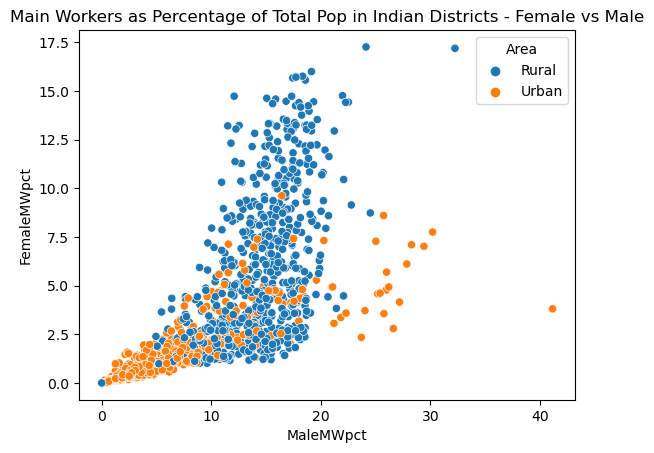

In [22]:
sns.scatterplot(data = district_work,
                x = 'MaleMWpct',
                y = 'FemaleMWpct',
                hue = 'Area')
plt.title('Main Workers as Percentage of Total Pop in Indian Districts - Female vs Male')
plt.show()
plt.close()

In [23]:
district_pop_set = set(zip(district_pop['State Code'],
                           district_pop['District Code'],
                           district_pop['Name']))

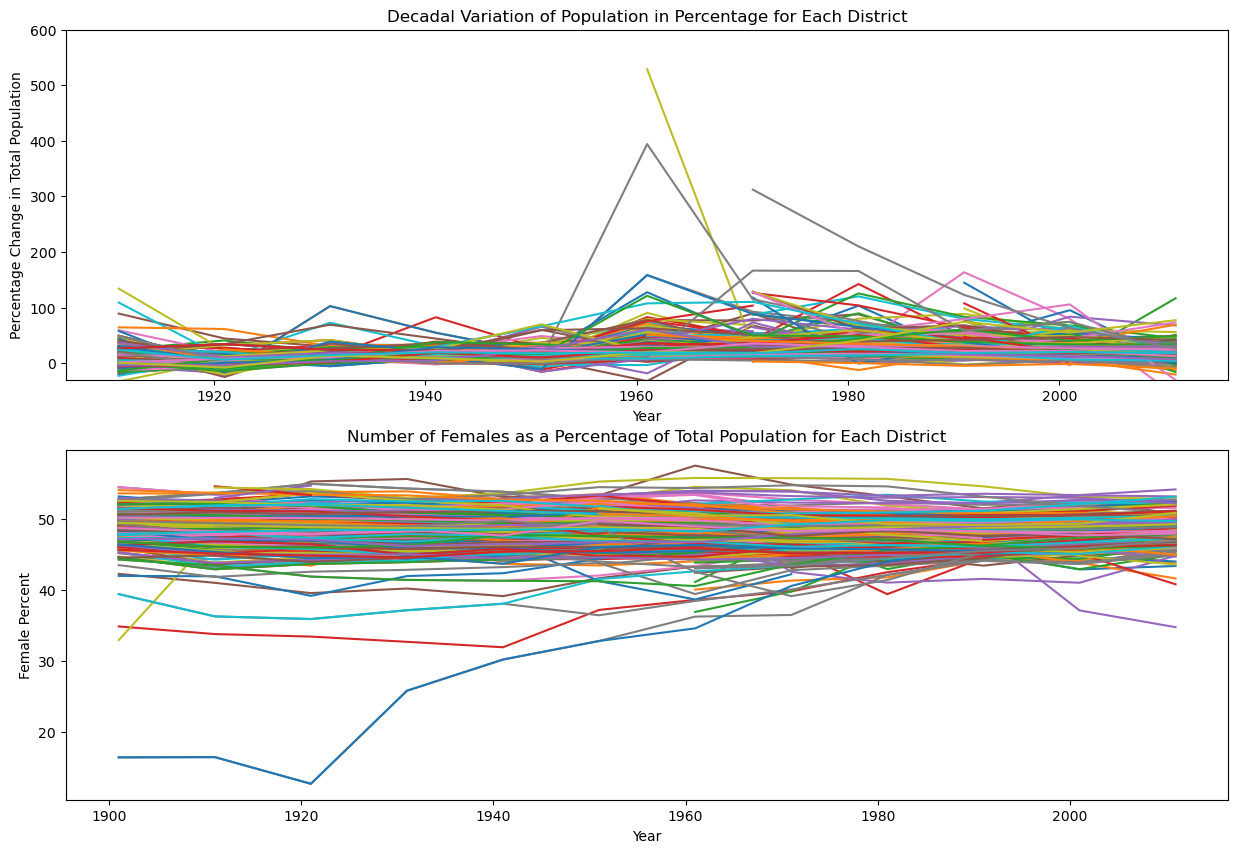

In [24]:
f, ax = plt.subplots(2, 1, figsize = (15, 10))

for state_code, district_code, name in district_pop_set:
    df_dist = district_pop.loc[((district_pop['State Code'] == state_code) &\
                                (district_pop['District Code'] == district_code) &\
                                (district_pop['Name'] == name)),\
                               ['Year', 'Pct_var_since_last', 'Female_pct']]
    ax[0].plot(df_dist[df_dist['Year'].astype(int) >= 1911].Year,
               df_dist[df_dist['Year'].astype(int) >= 1911].Pct_var_since_last,
               label = name)
    
    ax[1].plot(df_dist.Year,
               df_dist.Female_pct,
               label = name)
    

ax[0].set(xlabel = 'Year',
          ylabel = 'Percentage Change in Total Population',
          title = 'Decadal Variation of Population in Percentage for Each District',
          ylim = (-30, 600))
ax[1].set(xlabel = 'Year',
          ylabel = 'Female Percent',
          title = 'Number of Females as a Percentage of Total Population for Each District')
# f.legend() --> hiding the legends for better visibility


plt.show()
plt.close()

### Dealing with Null Values

The data is mostly gathered in linear bands. So, I will primarily use a Simple Linear Regression Model (separate model for each district) to predict the missing values. 

In an earlier version of this notebook, I tried to use a different approach (which is still described below in *italics*) - however, that was creating a large number of outliers (outliers in context of the overall dataset, they of course made sense for that district's non-null values and Linear Regression model trained on it). It's never good if the values we use to fill the null values are themselves outliers. So, I want to use corresponding values from the overall India dataset - just the country level data, not going to use individual State level data (since if information for a district is missing, chances are that information of that state would be missing as well because the missing values represent systemic issues; case in point - no census information available for Arunachal Pradesh or any of its districts until 1961). These are the steps I'm going to follow -

1) Overall country's population growth rate or sex ratio would be predictor for my Linear Regression model - matched on same census years.
2) However, I'll only use predictions from the Regression model when R2 (R-Squared) score of the model is above 55% (i.e., our predictor can explain more than 55% of the variance of the dependent variable) and we have less than or equal to 50% data missing (i.e., there are 6 or more non-null data points to train on for both Pct_var_since_last and Female_pct). I used these cutoff scores after randomly checking quite a few of these predictions - I believe breaching these conditions are creating more extreme values.
3) For the districts where I can't use predictions from the Linear Regression model, I'll use the mean of the existing values, multiplied by proportion of corresponding value of India for that census year and mean of India values - that way, the missing values will be somewhat correlated with overall country's values. For example, suppose district ABC is missing Female_pct for the year 1941, then I'll fill the null with - $\dfrac{(\bar F_{ABC} \times F_{IND}^ {1941})}{\bar F_{IND}}$,

where, $\bar F_{ABC}$ = mean of non-null Female_pct values in dist ABC, $F_{IND}^ {1941}$ = Female_pct value in India for 1941, $\bar F_{IND}$ = mean of Female_pct values in India


A few clarifications : for step 3 above, I know that the usual approach dictates that we should just be using the mean/median values - since that would keep the mean/median of the whole set intact. But I'm not trying to base this clustering off mean population percentage growth or mean women percentage, rather I want it to be based on how much population had grown for each census year or how much women percentage changed (or did not) over the years. Since I can't get actual values for the null points, I am estimating those rates/percentages off the next best actual data that I have - India's numbers. I also could have used corresponding state's numbers as estimators (provided that it's available which is mostly not the case), but I am not expecting all the districts of the same state to follow similar patterns (or fall in same cluster) - so why bother using sample statistics when population statistics is readily available (as in State's data is subset of India's data, and India is the whole population for the context of this task).

Also, I know that I could have used IterativeImputer with LinearRegression estimator instead of the individual LinearRegression models as outlined in point 1 - it would have been cleaner and easier to implement. But that would have replaced all the missing values irrespective of whether that particular districts' decadal population growth or female population percentage is linear or not. The checks illustrated in point 2 ensure that I am only applying the LinearRegression predicted values to replace nulls where the existing data is already (sort of) linear with respect to the country's overall rates.

*Earlier Approach : Our predictor would simply be the year, which if scaled (not needed for Linear Regression) would work as a placeholder for data point serial (1901-2011 --> 0-10).*

*However, as can be seen from the plot above, not all (especially in the Decadal Population Growth Percentage plot) the districts follow the linear pattern. So, we will use R2 (R-Squared) score to determine the linear tendencies for each district - we'll use a cutoff score of 55% for applying the Linear Regression prediction to the missing values, i.e., we'll use the model prediction when the predictor (Year or data point serial mentioned above) can explain more than 55% of the variance of the dependent variable (Pct_var_since_last or Female_pct).*

*For the districts whose linear model R2 score falls below that threshold, we'll fall back to simple linear interpolation that will just predict equidistant values based on preceding and succeeding values. But even that won't work if we have missing values at the beginning (1901 for Female_pct, 1911 for Pct_var_since_last) - in that case we'll fall back to district mean.*

In [25]:
# extracting data for India first
data_loader = np.load('ProcessedData/IndiaData.npz', allow_pickle = True)
# allow_pickle needs to be true for numpy to load non-numeric data from npz
df_India = pd.DataFrame(
    data = data_loader['data'],
    index = pd.MultiIndex.from_tuples(data_loader['index'],
                                      names = data_loader['index_names']),
    columns = pd.MultiIndex.from_tuples(data_loader['columns'],
                                        names = data_loader['columns_names'])
)
df_India

Female_pct             \
Year                                                 1901       1911   
State Code District Code Name                                          
00         000           INDIA                  49.279314  49.072299   
01         000           JAMMUKASHMIR           46.864252  46.683257   
02         000           HIMACHALPRADESH        46.931616  47.063118   
03         000           PUNJAB                 45.414173  43.812963   
04         000           CHANDIGARH             43.542587  41.872322   
05         000           UTTARAKHAND            47.866876  47.570974   
06         000           HARYANA                46.434010  45.506946   
07         000           NCTOFDELHI             46.300937  44.215430   
08         000           RAJASTHAN              47.503966  47.592286   
09         000           UTTARPRADESH           48.407355  47.794804   
10         000           BIHAR                  51.475812  51.240448   
11         000           SIKKIM                 47.817467  48.750000   
12         000           ARUNACHALPRADESH             NaN        NaN   
13         000           NAGALAND               49.312654  49.814141   
14         000           MANIPUR                50.914172  50.706194   
15         000           MIZORAM                52.684572  52.822245   
16         000           TRIPURA                46.634934  46.945513   
17         000           MEGHALAYA              50.882757  50.329057   
18         000           ASSAM                  47.888062  47.767964   
19         000           WESTBENGAL             48.589535  48.055231   
20         000           JHARKHAND              50.793485  50.517732   
21         000           ODISHA                 50.906137  51.351676   
22         000           CHHATTISGARH           51.133598  50.961258   
23         000           MADHYAPRADESH          49.292014  49.152854   
24         000           GUJARAT                48.817988  48.612156   
25         000           DAMANDIU               49.864084  50.973206   
26         000           DADRANAGARHAVELI       48.986820  49.159201   
27         000           MAHARASHTRA            49.451787  49.136607   
28         000           ANDHRAPRADESH          49.611188  49.787312   
29         000           KARNATAKA              49.580781  49.518120   
30         000           GOA                    52.179436  52.558387   
31         000           LAKSHADWEEP            51.534361  49.673652   
32         000           KERALA                 50.104201  50.201625   
33         000           TAMILNADU              51.074747  51.025503   
34         000           PUDUCHERRY                   NaN  51.410885   
35         000           ANDAMANNICOBARISLANDS  24.155138  26.036509   

                                                                      \
Year                                                 1921       1931   
State Code District Code Name                                          
00         000           INDIA                  48.851821  48.719001   
01         000           JAMMUKASHMIR           46.534115  46.378672   
02         000           HIMACHALPRADESH        47.090664  47.290269   
03         000           PUNJAB                 44.410946  44.893748   
04         000           CHANDIGARH             42.618430  42.880251   
05         000           UTTARAKHAND            47.797998  47.736459   
06         000           HARYANA                45.769653  45.761557   
07         000           NCTOFDELHI             42.312244  41.925450   
08         000           RAJASTHAN              47.249940  47.560235   
09         000           UTTARPRADESH           47.599263  47.458838   
10         000           BIHAR                  50.497907  49.876837   
11         000           SIKKIM                 49.227249  49.161263   
12         000           ARUNACHALPRADESH             NaN        NaN   
13         000           NAGALAND               49.787470  49.936257   
14         000

In [26]:
# need data for just India as a whole
df_India.xs('INDIA', level = 'Name')[['Female_pct', 'Pct_var_since_last']].transpose()

State Code                      00
District Code                  000
                   Year           
Female_pct         1901  49.279314
                   1911  49.072299
                   1921  48.851821
                   1931  48.719001
                   1941  48.587355
                   1951  48.619612
                   1961  48.480126
                   1971  48.181287
                   1981  48.286344
                   1991  48.092212
                   2001  48.264438
                   2011  48.526432
Pct_var_since_last 1911   5.750000
                   1921  -0.310000
                   1931  11.000000
                   1941  14.220000
                   1951  13.310000
                   1961  21.510000
                   1971  24.800000
                   1981  24.660000
                   1991  23.870000
                   2001  21.540000
                   2011  17.703015

In [27]:
df_India_only_reshaped = df_India.xs('INDIA', level = 'Name')\
                            [['Female_pct', 'Pct_var_since_last']].transpose()\
                            .unstack(level = 0).reset_index()
df_India_only_reshaped.columns = ['Year', 'Female_pct', 'Pct_var_since_last']
# df_India_only_reshaped['Year'] = df_India_only_reshaped.Year.astype(int)
# df_India_only_reshaped['Year'] = (df_India_only_reshaped.Year - 1901) // 10
mean_IND_popgrthpct = np.nanmean(df_India_only_reshaped.Pct_var_since_last)
mean_IND_fempct = np.mean(df_India_only_reshaped.Female_pct)
print(mean_IND_popgrthpct, mean_IND_fempct)
df_India_only_reshaped

16.186637713083265 48.580019953691426


,Year,Female_pct,Pct_var_since_last
0,1901,49.279314,NaN
1,1911,49.072299,5.750000
2,1921,48.851821,-0.310000
3,1931,48.719001,11.000000
4,1941,48.587355,14.220000
5,1951,48.619612,13.310000
6,1961,48.480126,21.510000
7,1971,48.181287,24.800000
8,1981,48.286344,24.660000
9,1991,48.092212,23.870000


In [28]:
usage_counter = {
    'Pct_var_since_last' : {'LinReg' : 0, 'Mean' : 0},
    'Female_pct' : {'LinReg' : 0, 'Mean' : 0}
} # to keep track of how much each method was used

pop_growth_mean = {}
fem_pct_mean = {}
# dictionaries to store 'unadulterated' mean values - before nulls are filled
# will be useful later

for state_code, district_code, name in district_pop_set:
    df_dist = district_pop.loc[((district_pop['State Code'] == state_code) &\
                                (district_pop['District Code'] == district_code) &\
                                (district_pop['Name'] == name)),
                               ['Year', 'Pct_var_since_last', 'Female_pct']]
    df_dist_wIndia = pd.merge(df_dist,
                              df_India_only_reshaped,
                              on = 'Year',
                              suffixes = ('_dist', '_IND'),
                              validate = '1:1')
    growth_pct_df = df_dist_wIndia[['Year','Pct_var_since_last_dist',\
                                    'Pct_var_since_last_IND']].iloc[1:]
    # removing the 1901 entry from consideration for decadal population variation calculation
    
    current_pop_growth_mean = np.nanmean(growth_pct_df.Pct_var_since_last_dist)
    current_fem_pct_mean = np.nanmean(df_dist_wIndia.Female_pct_dist)
    pop_growth_mean[(state_code, district_code, name)] = current_pop_growth_mean
    fem_pct_mean[(state_code, district_code, name)] = current_fem_pct_mean
    # these dictionaries have state code, district code, name tuples as keys and mean
    # (before predictions for nulls are filled) as values, planning to use these as
    # features later. the means themselves are useful for estimation below. these
    # dictinaries will be filled for every district, even if they don't have null values
    
    missing_decadal_var_count = growth_pct_df.Pct_var_since_last_dist.isna().sum()
    missing_female_pct_count = df_dist_wIndia.Female_pct_dist.isna().sum()
    
    if (missing_decadal_var_count > 0): # dealing with null values in Pct_var_since_last
        # Simple Linear Regression Model
        linreg_X_train = growth_pct_df.loc[(~growth_pct_df.Pct_var_since_last_dist.isna()),\
                                          ['Pct_var_since_last_IND']].values.reshape(-1, 1)
        linreg_X_missing = growth_pct_df.loc[(growth_pct_df.Pct_var_since_last_dist.isna()),\
                                        ['Pct_var_since_last_IND']].values.reshape(-1, 1)
        linreg_y_train = growth_pct_df.loc[(~growth_pct_df.Pct_var_since_last_dist.isna()),\
                                           'Pct_var_since_last_dist']
        linmodel = LinearRegression()
        linmodel.fit(linreg_X_train, linreg_y_train)
        r2 = linmodel.score(linreg_X_train, linreg_y_train)
        if ((missing_decadal_var_count <= 5) & (r2 > 0.55)):
        # out of total 11 years, we have data for 6 or more years, and Pct_var_since_last_IND
        # can explain more than 55% of variance in Pct_var_since_last_dist for those
        # available data points - hence, Regression model prediction would be used.
            predicted = linmodel.predict(linreg_X_missing)
            district_pop.loc[((district_pop['State Code'] == state_code) &\
                              (district_pop['District Code'] == district_code) &\
                              (district_pop['Name'] == name) &\
                              (district_pop['Year'].astype(int) >= 1911) &\
                              (district_pop['Pct_var_since_last'].isna())),\
                             'Pct_var_since_last'] = predicted
            # updating the predictions in the original dataframe
            usage_counter['Pct_var_since_last']['LinReg'] += 1

        else: # proprtionate mean values to be used
            
            # mean of the available values is stored in current_pop_growth_mean
            mean_estimation_ser = (current_pop_growth_mean *\
                             growth_pct_df.loc[growth_pct_df.Pct_var_since_last_dist.isna(),\
                                              'Pct_var_since_last_IND']) \
                                / mean_IND_popgrthpct
            district_pop.loc[((district_pop['State Code'] == state_code) &\
                              (district_pop['District Code'] == district_code) &\
                              (district_pop['Name'] == name) &\
                              (district_pop['Year'].astype(int) >= 1911) &\
                              (district_pop['Pct_var_since_last'].isna())),\
                             'Pct_var_since_last'] = mean_estimation_ser.values
            # updating the predictions in the original dataframe
            usage_counter['Pct_var_since_last']['Mean'] += 1
    
    
    if (missing_female_pct_count > 0): # dealing with null values in Female_pct
        # Simple Linear Regression Model
        linreg_X_train = df_dist_wIndia.loc[(~df_dist_wIndia.Female_pct_dist.isna()),\
                                             'Female_pct_IND'].values.reshape(-1, 1)
        linreg_X_missing = df_dist_wIndia.loc[(df_dist_wIndia.Female_pct_dist.isna()),\
                                               'Female_pct_IND'].values.reshape(-1, 1)
        linreg_y_train = df_dist_wIndia.loc[(~df_dist_wIndia.Female_pct_dist.isna()),\
                                            'Female_pct_dist']
        linmodel = LinearRegression()
        linmodel.fit(linreg_X_train, linreg_y_train)
        r2 = linmodel.score(linreg_X_train, linreg_y_train)
        if ((missing_female_pct_count <= 6) & (r2 > 0.55)):
        # out of total 12 years, we have data for 6 or more years, and Female_pct_IND
        # can explain more than 55% of variance in Female_pct_dist for those
        # available data points - hence, Regression model prediction would be used.
            predicted = linmodel.predict(linreg_X_missing)
            district_pop.loc[((district_pop['State Code'] == state_code) &\
                              (district_pop['District Code'] == district_code) &\
                              (district_pop['Name'] == name) &\
                              (district_pop['Female_pct'].isna())),\
                             'Female_pct'] = predicted
            # updating the predictions in the original dataframe
            usage_counter['Female_pct']['LinReg'] += 1
            
        else: # proprtionate mean values to be used
            
            # mean of the available values is stored in current_fem_pct_mean
            mean_estimation_ser = (current_fem_pct_mean *\
                                 df_dist_wIndia.loc[df_dist_wIndia.Female_pct_dist.isna(),\
                                              'Female_pct_IND']) / mean_IND_fempct
            district_pop.loc[((district_pop['State Code'] == state_code) &\
                              (district_pop['District Code'] == district_code) &\
                              (district_pop['Name'] == name) &\
                              (district_pop['Female_pct'].isna())),\
                             'Female_pct'] = mean_estimation_ser.values
            # updating the predictions in the original dataframe
            usage_counter['Female_pct']['Mean'] += 1
            

            
print('Methodologies used for filling Null values :')
print('Pct_var_since_last - Linear Regression and Proportional Mean were used for '\
      '{} & {} districts respectively.'.format(usage_counter['Pct_var_since_last']['LinReg'],
                                           usage_counter['Pct_var_since_last']['Mean']))
print('Female_pct - Linear Regression and Proportional Mean were used for '\
      '{} & {} districts respectively.'.format(usage_counter['Female_pct']['LinReg'],
                                           usage_counter['Female_pct']['Mean']))

Methodologies used for filling Null values :
Pct_var_since_last - Linear Regression and Proportional Mean were used for 9 & 88 districts respectively.
Female_pct - Linear Regression and Proportional Mean were used for 29 & 96 districts respectively.


In [29]:
# rechecking Null count
print('District Population Decadal Variation Dataset')
print('Number of Null values in Pct_var_since_last column, minus Census Year 1901 : {}.'\
      .format(district_pop.loc[district_pop['Year'].astype(int) >= 1911,\
                               'Pct_var_since_last'].isna().sum()))
print('Number of Null values in Female_pct column : {}.'\
      .format(district_pop.Female_pct.isna().sum()))

District Population Decadal Variation Dataset
Number of Null values in Pct_var_since_last column, minus Census Year 1901 : 0.
Number of Null values in Female_pct column : 0.


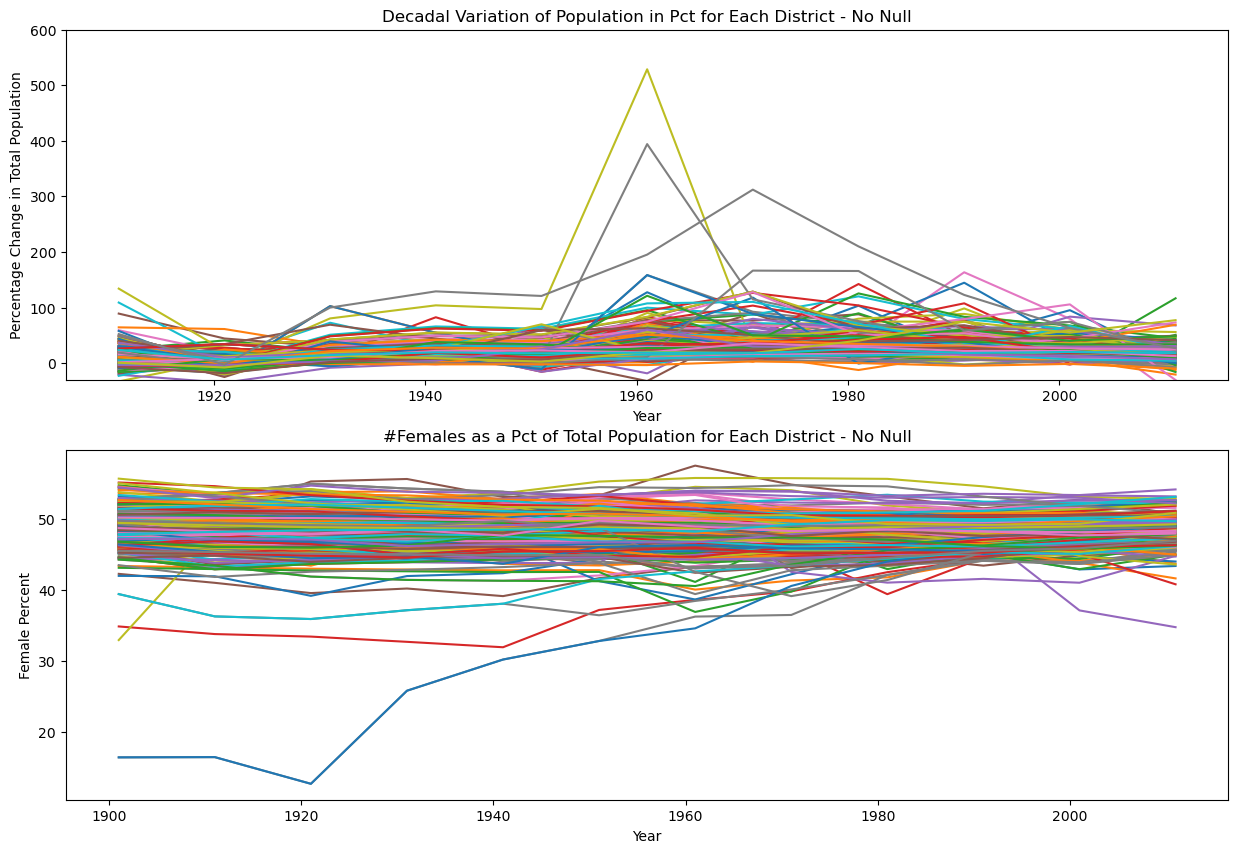

In [30]:
# recreating the plot after filling null values
f, ax = plt.subplots(2, 1, figsize = (15, 10))

for state_code, district_code, name in district_pop_set:
    df_dist = district_pop.loc[((district_pop['State Code'] == state_code) &\
                                (district_pop['District Code'] == district_code) &\
                                (district_pop['Name'] == name)),\
                               ['Year', 'Pct_var_since_last', 'Female_pct']]
    ax[0].plot(df_dist[df_dist['Year'].astype(int) >= 1911].Year,
               df_dist[df_dist['Year'].astype(int) >= 1911].Pct_var_since_last,
               label = name)
    
    ax[1].plot(df_dist.Year, df_dist.Female_pct, label = name)
    

ax[0].set(xlabel = 'Year',
          ylabel = 'Percentage Change in Total Population',
          title = 'Decadal Variation of Population in Pct for Each District - No Null',
          ylim = (-30, 600))
ax[1].set(xlabel = 'Year',
          ylabel = 'Female Percent',
          title = '#Females as a Pct of Total Population for Each District - No Null')
# f.legend() --> hiding the legends for better visibility


plt.show()
plt.close()

### Populating State/UT Names

Now that I have eliminated null values, I am almost ready to pivot the tables so that we can reach the final shape for the datasets. One last thing I want to do is replace State and District codes with names as identifiers. I already have District names in my main district datasets, just need to add State names there from state datasets by matching state codes. After this, StateName and DistrictName will be the unique identifier for each district.

In [31]:
state_ut_code_name = dict(zip(state_ut_pop['State Code'], state_ut_pop['Name']))
# we can use the same dictionary for both tables, since we have already
# validated that code and name combinations match in both tables

state_ut_code_name

{'35': 'ANDAMANNICOBARISLANDS',
 '28': 'ANDHRAPRADESH',
 '12': 'ARUNACHALPRADESH',
 '18': 'ASSAM',
 '10': 'BIHAR',
 '04': 'CHANDIGARH',
 '22': 'CHHATTISGARH',
 '26': 'DADRANAGARHAVELI',
 '25': 'DAMANDIU',
 '30': 'GOA',
 '24': 'GUJARAT',
 '06': 'HARYANA',
 '02': 'HIMACHALPRADESH',
 '01': 'JAMMUKASHMIR',
 '20': 'JHARKHAND',
 '29': 'KARNATAKA',
 '32': 'KERALA',
 '31': 'LAKSHADWEEP',
 '23': 'MADHYAPRADESH',
 '27': 'MAHARASHTRA',
 '14': 'MANIPUR',
 '17': 'MEGHALAYA',
 '15': 'MIZORAM',
 '13': 'NAGALAND',
 '07': 'NCTOFDELHI',
 '21': 'ODISHA',
 '34': 'PUDUCHERRYUT',
 '03': 'PUNJAB',
 '08': 'RAJASTHAN',
 '11': 'SIKKIM',
 '33': 'TAMILNADU',
 '16': 'TRIPURA',
 '05': 'UTTARAKHAND',
 '09': 'UTTARPRADESH',
 '19': 'WESTBENGAL'}

In [32]:
district_pop = district_pop.copy()
district_work = district_work.copy()
district_pop.loc[:, 'StateName'] = district_pop['State Code'].map(state_ut_code_name)
district_work.loc[:, 'StateName'] = district_work['State Code'].map(state_ut_code_name)
district_pop = district_pop.astype({'StateName' : 'category'})
district_work = district_work.astype({'StateName' : 'category'})
district_work

,State Code,District Code,Name,Area,Name_TotPop,MaleMWpct,FemaleMWpct,StateName
2,35,638,NICOBARS,Rural,36842,20.655773,4.421584,ANDAMANNICOBARISLANDS
3,35,638,NICOBARS,Urban,36842,0.000000,0.000000,ANDAMANNICOBARISLANDS
4,35,639,NORTHMIDDLEANDAMAN,Rural,105597,22.079226,4.471718,ANDAMANNICOBARISLANDS
5,35,639,NORTHMIDDLEANDAMAN,Urban,105597,0.606078,0.172353,ANDAMANNICOBARISLANDS
6,35,640,SOUTHANDAMAN,Rural,238142,10.663386,2.017284,ANDAMANNICOBARISLANDS
...,...,...,...,...,...,...,...,...
1345,19,343,SOUTHTWENTYFOURPARGANAS,Urban,8161961,5.932533,0.998142,WESTBENGAL
1346,19,344,PASCHIMMEDINIPUR,Rural,5913457,16.680209,3.539994,WESTBENGAL
1347,19,344,PASCHIMMEDINIPUR,Urban,5913457,2.737485,0.518090,WESTBENGAL
1348,19,345,PURBAMEDINIPUR,Rural,5095875,15.594554,1.982898,WESTBENGAL


In [33]:
# our mean dictionaries also need to switch from state code to state name
pop_growth_mean_names = {}
fem_pct_mean_names = {}
for (state_code, district_code, name), mean in pop_growth_mean.items():
    state_name = state_ut_code_name[state_code]
    pop_growth_mean_names[(name, state_name)] = mean
for (state_code, district_code, name), mean in fem_pct_mean.items():
    state_name = state_ut_code_name[state_code]
    fem_pct_mean_names[(name, state_name)] = mean

### Pivoting the Datasets, and a few New Features

In [34]:
district_pop_pivot = district_pop.pivot_table(values = ['Pct_var_since_last', 'Female_pct'],
                                         index = ['Name', 'StateName'],
                                         columns =['Year'],
                                         observed = True)
district_pop_pivot

Female_pct             \
Year                                                1901       1911   
Name                    StateName                                     
NICOBARS                ANDAMANNICOBARISLANDS  45.676547  45.191653   
NORTHMIDDLEANDAMAN      ANDAMANNICOBARISLANDS  16.430919  16.468341   
SOUTHANDAMAN            ANDAMANNICOBARISLANDS  16.428764  16.457449   
ADILABAD                ANDHRAPRADESH          49.767194  49.394224   
NIZAMABAD               ANDHRAPRADESH          50.144858  50.145012   
...                                                  ...        ...   
HAORA                   WESTBENGAL             48.322426  47.149980   
KOLKATA                 WESTBENGAL             34.895079  33.820707   
SOUTHTWENTYFOURPARGANAS WESTBENGAL             48.116473  47.208953   
PASCHIMMEDINIPUR        WESTBENGAL             50.155053  49.995968   
PURBAMEDINIPUR          WESTBENGAL             50.155006  49.995988   

                                                                     \
Year                                                1921       1931   
Name                    StateName                                     
NICOBARS                ANDAMANNICOBARISLANDS  43.464193  46.835938   
NORTHMIDDLEANDAMAN      ANDAMANNICOBARISLANDS  12.700029  25.832547   
SOUTHANDAMAN            ANDAMANNICOBARISLANDS  12.705667  25.825851   
ADILABAD                ANDHRAPRADESH          48.837121  48.886006   
NIZAMABAD               ANDHRAPRADESH          50.402421  49.755365   
...                                                  ...        ...   
HAORA                   WESTBENGAL             46.345559  45.482483   
KOLKATA                 WESTBENGAL             33.464912  32.725302   
SOUTHTWENTYFOURPARGANAS WESTBENGAL             46.564336  46.404160   
PASCHIMMEDINIPUR        WESTBENGAL             49.762899  49.375544   
PURBAMEDINIPUR          WESTBENGAL             49.762955  49.375591   

                                                                     \
Year                                                1941       1951   
Name                    StateName                                     
NICOBARS                ANDAMANNICOBARISLANDS  47.108898  47.364477   
NORTHMIDDLEANDAMAN      ANDAMANNICOBARISLANDS  30.224924  32.841328   
SOUTHANDAMAN            ANDAMANNICOBARISLANDS  30.234512  32.846715   
ADILABAD                ANDHRAPRADESH          49.342754  50.193963   
NIZAMABAD               ANDHRAPRADESH          49.843247  50.463793   
...                                                  ...        ...   
HAORA                   WESTBENGAL             44.076443  44.754939   
KOLKATA                 WESTBENGAL             31.961330  37.224127   
SOUTHTWENTYFOURPARGANAS WESTBENGAL             45.843134  46.258002   
PASCHIMMEDINIPUR        WESTBENGAL             48.860737  48.980004   
PURBAMEDINIPUR          WESTBENGAL             48.860762  48.673377   

                                                                     \
Year                                                1961       1971   
Name                    StateName                                     
NICOBARS                ANDAMANNICOBARISLANDS  46.576942  43.937226   
NORTHMIDDLEANDAMAN      ANDAMANNICOBARISLANDS  34.627797  40.606656   
SOUTHANDAMAN            ANDAMANNICOBARISLANDS  36.285068  36.515563   
ADILABAD                ANDHRAPRADESH          49.514115  49.387898   
NIZAMABAD               ANDHRAPRADESH          50.176476  49.965354   
...                                                  ...        ...   
HAORA                   WESTBENGAL             44.694397  45.446464   
KOLKATA                 WESTBENGAL             38.639970  39.841858   
SOUTHTWENTYFOURPARGANAS WESTBENGAL             47.943863  47.826976   
PASCHIMMEDINIPUR        WESTBENGAL             48.792453  48.631590   
PURBAMEDINIPUR          WESTBENGAL             48.755971  48.556791   

                                                                  

In [35]:
district_work_pivot = district_work.pivot_table(values = ['MaleMWpct', 'FemaleMWpct'],
                                           index = ['Name', 'StateName'],
                                           columns = ['Area'],
                                           observed = True)
district_work_pivot

FemaleMWpct            \
Area                                                Rural     Urban   
Name                    StateName                                     
NICOBARS                ANDAMANNICOBARISLANDS    4.421584  0.000000   
NORTHMIDDLEANDAMAN      ANDAMANNICOBARISLANDS    4.471718  0.172353   
SOUTHANDAMAN            ANDAMANNICOBARISLANDS    2.017284  4.121491   
ADILABAD                ANDHRAPRADESH           12.154650  1.640973   
NIZAMABAD               ANDHRAPRADESH           14.581425  1.949411   
...                                                   ...       ...   
HAORA                   WESTBENGAL               1.111313  2.528603   
KOLKATA                 WESTBENGAL               0.000000  5.691381   
SOUTHTWENTYFOURPARGANAS WESTBENGAL               1.852619  0.998142   
PASCHIMMEDINIPUR        WESTBENGAL               3.539994  0.518090   
PURBAMEDINIPUR          WESTBENGAL               1.982898  0.349832   

                                               MaleMWpct             
Area                                               Rural      Urban  
Name                    StateName                                    
NICOBARS                ANDAMANNICOBARISLANDS  20.655773   0.000000  
NORTHMIDDLEANDAMAN      ANDAMANNICOBARISLANDS  22.079226   0.606078  
SOUTHANDAMAN            ANDAMANNICOBARISLANDS  10.663386  17.261970  
ADILABAD                ANDHRAPRADESH          14.910630   5.586270  
NIZAMABAD               ANDHRAPRADESH          15.882077   4.666851  
...                                                  ...        ...  
HAORA                   WESTBENGAL              8.490506  16.357036  
KOLKATA                 WESTBENGAL              0.000000  26.006462  
SOUTHTWENTYFOURPARGANAS WESTBENGAL             13.772609   5.932533  
PASCHIMMEDINIPUR        WESTBENGAL             16.680209   2.737485  
PURBAMEDINIPUR          WESTBENGAL             15.594554   2.508912  

[640 rows x 4 columns]

Now that both tables have been pivoted I have data for each district in a row, and now I can introduce a few features specific to each district -
1) The mean dictionaries that I had built before filling the null values, contains 'real' mean of Population Growth Rate and Female Population Percentage - based on the actual available data, rather than what I had filled. I will use those 2 dictionaries as 2 new features in Population table.
2) I also wanted a separate feature for Total Main Workers in the Work table - it will be sum of Male and Female Main Workers in both Rural & Urban Areas, and still as a percentage of Total population of that district.

In [36]:
district_pop_pivot['AvgPopGrowth'] = district_pop_pivot.index.map(pop_growth_mean_names)
district_pop_pivot['AvgFemPct'] = district_pop_pivot.index.map(fem_pct_mean_names)
district_pop_pivot

Female_pct             \
Year                                                1901       1911   
Name                    StateName                                     
NICOBARS                ANDAMANNICOBARISLANDS  45.676547  45.191653   
NORTHMIDDLEANDAMAN      ANDAMANNICOBARISLANDS  16.430919  16.468341   
SOUTHANDAMAN            ANDAMANNICOBARISLANDS  16.428764  16.457449   
ADILABAD                ANDHRAPRADESH          49.767194  49.394224   
NIZAMABAD               ANDHRAPRADESH          50.144858  50.145012   
...                                                  ...        ...   
HAORA                   WESTBENGAL             48.322426  47.149980   
KOLKATA                 WESTBENGAL             34.895079  33.820707   
SOUTHTWENTYFOURPARGANAS WESTBENGAL             48.116473  47.208953   
PASCHIMMEDINIPUR        WESTBENGAL             50.155053  49.995968   
PURBAMEDINIPUR          WESTBENGAL             50.155006  49.995988   

                                                                     \
Year                                                1921       1931   
Name                    StateName                                     
NICOBARS                ANDAMANNICOBARISLANDS  43.464193  46.835938   
NORTHMIDDLEANDAMAN      ANDAMANNICOBARISLANDS  12.700029  25.832547   
SOUTHANDAMAN            ANDAMANNICOBARISLANDS  12.705667  25.825851   
ADILABAD                ANDHRAPRADESH          48.837121  48.886006   
NIZAMABAD               ANDHRAPRADESH          50.402421  49.755365   
...                                                  ...        ...   
HAORA                   WESTBENGAL             46.345559  45.482483   
KOLKATA                 WESTBENGAL             33.464912  32.725302   
SOUTHTWENTYFOURPARGANAS WESTBENGAL             46.564336  46.404160   
PASCHIMMEDINIPUR        WESTBENGAL             49.762899  49.375544   
PURBAMEDINIPUR          WESTBENGAL             49.762955  49.375591   

                                                                     \
Year                                                1941       1951   
Name                    StateName                                     
NICOBARS                ANDAMANNICOBARISLANDS  47.108898  47.364477   
NORTHMIDDLEANDAMAN      ANDAMANNICOBARISLANDS  30.224924  32.841328   
SOUTHANDAMAN            ANDAMANNICOBARISLANDS  30.234512  32.846715   
ADILABAD                ANDHRAPRADESH          49.342754  50.193963   
NIZAMABAD               ANDHRAPRADESH          49.843247  50.463793   
...                                                  ...        ...   
HAORA                   WESTBENGAL             44.076443  44.754939   
KOLKATA                 WESTBENGAL             31.961330  37.224127   
SOUTHTWENTYFOURPARGANAS WESTBENGAL             45.843134  46.258002   
PASCHIMMEDINIPUR        WESTBENGAL             48.860737  48.980004   
PURBAMEDINIPUR          WESTBENGAL             48.860762  48.673377   

                                                                     \
Year                                                1961       1971   
Name                    StateName                                     
NICOBARS                ANDAMANNICOBARISLANDS  46.576942  43.937226   
NORTHMIDDLEANDAMAN      ANDAMANNICOBARISLANDS  34.627797  40.606656   
SOUTHANDAMAN            ANDAMANNICOBARISLANDS  36.285068  36.515563   
ADILABAD                ANDHRAPRADESH          49.514115  49.387898   
NIZAMABAD               ANDHRAPRADESH          50.176476  49.965354   
...                                                  ...        ...   
HAORA                   WESTBENGAL             44.694397  45.446464   
KOLKATA                 WESTBENGAL             38.639970  39.841858   
SOUTHTWENTYFOURPARGANAS WESTBENGAL             47.943863  47.826976   
PASCHIMMEDINIPUR        WESTBENGAL             48.792453  48.631590   
PURBAMEDINIPUR          WESTBENGAL             48.755971  48.556791   

                                                                  

In [37]:
district_work_pivot['TotMWpct'] = np.sum(district_work_pivot[[('FemaleMWpct', 'Rural'),
                                                              ('FemaleMWpct', 'Urban'),
                                                              ('MaleMWpct', 'Rural'),
                                                              ('MaleMWpct', 'Urban')]],
                                         axis = 1)
district_work_pivot

FemaleMWpct            \
Area                                                Rural     Urban   
Name                    StateName                                     
NICOBARS                ANDAMANNICOBARISLANDS    4.421584  0.000000   
NORTHMIDDLEANDAMAN      ANDAMANNICOBARISLANDS    4.471718  0.172353   
SOUTHANDAMAN            ANDAMANNICOBARISLANDS    2.017284  4.121491   
ADILABAD                ANDHRAPRADESH           12.154650  1.640973   
NIZAMABAD               ANDHRAPRADESH           14.581425  1.949411   
...                                                   ...       ...   
HAORA                   WESTBENGAL               1.111313  2.528603   
KOLKATA                 WESTBENGAL               0.000000  5.691381   
SOUTHTWENTYFOURPARGANAS WESTBENGAL               1.852619  0.998142   
PASCHIMMEDINIPUR        WESTBENGAL               3.539994  0.518090   
PURBAMEDINIPUR          WESTBENGAL               1.982898  0.349832   

                                               MaleMWpct              TotMWpct  
Area                                               Rural      Urban             
Name                    StateName                                               
NICOBARS                ANDAMANNICOBARISLANDS  20.655773   0.000000  25.077357  
NORTHMIDDLEANDAMAN      ANDAMANNICOBARISLANDS  22.079226   0.606078  27.329375  
SOUTHANDAMAN            ANDAMANNICOBARISLANDS  10.663386  17.261970  34.064130  
ADILABAD                ANDHRAPRADESH          14.910630   5.586270  34.292522  
NIZAMABAD               ANDHRAPRADESH          15.882077   4.666851  37.079764  
...                                                  ...        ...        ...  
HAORA                   WESTBENGAL              8.490506  16.357036  28.487459  
KOLKATA                 WESTBENGAL              0.000000  26.006462  31.697843  
SOUTHTWENTYFOURPARGANAS WESTBENGAL             13.772609   5.932533  22.555903  
PASCHIMMEDINIPUR        WESTBENGAL             16.680209   2.737485  23.475777  
PURBAMEDINIPUR          WESTBENGAL             15.594554   2.508912  20.436196  

[640 rows x 5 columns]

Without further ado, let's join these 2 tables now.

In [38]:
df_districts = district_pop_pivot.join(district_work_pivot)
df_districts

Female_pct             \
Year                                                1901       1911   
Name                    StateName                                     
NICOBARS                ANDAMANNICOBARISLANDS  45.676547  45.191653   
NORTHMIDDLEANDAMAN      ANDAMANNICOBARISLANDS  16.430919  16.468341   
SOUTHANDAMAN            ANDAMANNICOBARISLANDS  16.428764  16.457449   
ADILABAD                ANDHRAPRADESH          49.767194  49.394224   
NIZAMABAD               ANDHRAPRADESH          50.144858  50.145012   
...                                                  ...        ...   
HAORA                   WESTBENGAL             48.322426  47.149980   
KOLKATA                 WESTBENGAL             34.895079  33.820707   
SOUTHTWENTYFOURPARGANAS WESTBENGAL             48.116473  47.208953   
PASCHIMMEDINIPUR        WESTBENGAL             50.155053  49.995968   
PURBAMEDINIPUR          WESTBENGAL             50.155006  49.995988   

                                                                     \
Year                                                1921       1931   
Name                    StateName                                     
NICOBARS                ANDAMANNICOBARISLANDS  43.464193  46.835938   
NORTHMIDDLEANDAMAN      ANDAMANNICOBARISLANDS  12.700029  25.832547   
SOUTHANDAMAN            ANDAMANNICOBARISLANDS  12.705667  25.825851   
ADILABAD                ANDHRAPRADESH          48.837121  48.886006   
NIZAMABAD               ANDHRAPRADESH          50.402421  49.755365   
...                                                  ...        ...   
HAORA                   WESTBENGAL             46.345559  45.482483   
KOLKATA                 WESTBENGAL             33.464912  32.725302   
SOUTHTWENTYFOURPARGANAS WESTBENGAL             46.564336  46.404160   
PASCHIMMEDINIPUR        WESTBENGAL             49.762899  49.375544   
PURBAMEDINIPUR          WESTBENGAL             49.762955  49.375591   

                                                                     \
Year                                                1941       1951   
Name                    StateName                                     
NICOBARS                ANDAMANNICOBARISLANDS  47.108898  47.364477   
NORTHMIDDLEANDAMAN      ANDAMANNICOBARISLANDS  30.224924  32.841328   
SOUTHANDAMAN            ANDAMANNICOBARISLANDS  30.234512  32.846715   
ADILABAD                ANDHRAPRADESH          49.342754  50.193963   
NIZAMABAD               ANDHRAPRADESH          49.843247  50.463793   
...                                                  ...        ...   
HAORA                   WESTBENGAL             44.076443  44.754939   
KOLKATA                 WESTBENGAL             31.961330  37.224127   
SOUTHTWENTYFOURPARGANAS WESTBENGAL             45.843134  46.258002   
PASCHIMMEDINIPUR        WESTBENGAL             48.860737  48.980004   
PURBAMEDINIPUR          WESTBENGAL             48.860762  48.673377   

                                                                     \
Year                                                1961       1971   
Name                    StateName                                     
NICOBARS                ANDAMANNICOBARISLANDS  46.576942  43.937226   
NORTHMIDDLEANDAMAN      ANDAMANNICOBARISLANDS  34.627797  40.606656   
SOUTHANDAMAN            ANDAMANNICOBARISLANDS  36.285068  36.515563   
ADILABAD                ANDHRAPRADESH          49.514115  49.387898   
NIZAMABAD               ANDHRAPRADESH          50.176476  49.965354   
...                                                  ...        ...   
HAORA                   WESTBENGAL             44.694397  45.446464   
KOLKATA                 WESTBENGAL             38.639970  39.841858   
SOUTHTWENTYFOURPARGANAS WESTBENGAL             47.943863  47.826976   
PASCHIMMEDINIPUR        WESTBENGAL             48.792453  48.631590   
PURBAMEDINIPUR          WESTBENGAL             48.755971  48.556791   

                                                                  

In [39]:
df_districts.describe().transpose()

count       mean        std        min        25%  \
                   Year                                                       
Female_pct         1901   640.0  48.929607   2.971457  16.428764  47.470631   
                   1911   640.0  48.736758   3.023234  16.457449  47.207812   
                   1921   640.0  48.522264   3.171246  12.700029  46.976210   
                   1931   640.0  48.411317   2.659112  25.825851  46.918223   
                   1941   640.0  48.390230   2.452593  30.224924  46.909481   
                   1951   640.0  48.458289   2.355951  32.841328  47.043867   
                   1961   640.0  48.338425   2.353308  34.627797  47.032408   
                   1971   640.0  48.079141   2.080884  36.515563  46.875669   
                   1981   640.0  48.136358   1.891007  39.445691  46.961791   
                   1991   640.0  48.024292   1.644709  41.606925  46.879841   
                   2001   640.0  48.250451   1.702061  37.157094  47.220677   
                   2011   640.0  48.547080   1.638332  34.792570  47.542127   
Pct_var_since_last 1911   640.0   9.758683  14.384261 -33.120000   1.869495   
                   1921   640.0   0.735693   8.968256 -35.354765  -4.248702   
                   1931   640.0  13.392000  10.810856  -8.412628   7.229683   
                   1941   640.0  15.820250  10.940458  -2.423842  10.201679   
                   1951   640.0  14.427646  12.045085 -15.681833   8.005414   
                   1961   640.0  27.003568  31.149630 -32.443940  16.338919   
                   1971   640.0  28.912155  19.848507   2.211530  20.320344   
                   1981   640.0  28.209620  16.902712 -12.499545  21.040596   
                   1991   640.0  27.206838  14.975493  -5.018641  19.913506   
                   2001   640.0  22.915116  11.908881  -2.767453  15.766756   
                   2011   640.0  17.759388  11.285370 -58.477065  12.101644   
AvgPopGrowth              640.0  19.438936  11.044606  -2.724502  14.152814   
AvgFemPct                 640.0  48.366081   2.067750  32.129755  47.204879   
FemaleMWpct        Rural  640.0   5.747054   3.922980   0.000000   2.570713   
                   Urban  640.0   1.417039   1.486376   0.000000   0.444813   
MaleMWpct          Rural  640.0  13.868422   4.341574   0.000000  11.585091   
                   Urban  640.0   6.075259   5.522801   0.000000   2.446504   
TotMWpct                  640.0  27.107774   6.914873  11.513079  22.117534   

                                50%        75%         max  
                   Year                                     
Female_pct         1901   49.370641  50.500162   55.744008  
                   1911   49.274492  50.425533   54.681231  
                   1921   48.899955  50.186840   55.345276  
                   1931   48.828843  49.994947   55.692713  
                   1941   48.815201  49.861269   53.898686  
                   1951   48.870758  49.920734   55.328043  
                   1961   48.704240  49.821229   57.577031  
                   1971   48.456703  49.415749   55.808443  
                   1981   48.414491  49.347155   55.711464  
                   1991   48.230902  49.099316   54.652581  
                   2001   48.407298  49.343662   53.424025  
                   2011   48.698604  49.562465   54.220872  
Pct_var_since_last 1911    8.187401  15.851003  133.988457  
                   1921   -0.437444   4.454400   61.253972  
                   1931   11.559109  16.754582  102.492193  
                   1941   14.095887  18.395818  129.046626  
                   1951   12.424418  18.331047  120.788368  
                   1961   21.438832  28.989608  528.782918  
                   1971   25.489357  30.953686  312.166164  
                   1981   24.896069  30.506084  209.970622  
                   1991   24.508000  30.026070  163.394802  
                   2001   21.832737  27.598288  105.595525  
                   2011   17.0670

### Scaling
I plan on applying KMeans algorithm to cluster this dataset. Although I know that KMeans prefers scaled data, I thought we could do without scaling on this dataset since each row consists of data of a single district - and related features are in similar scale for every district. I tried to run a basic model on it, and the results were horrible - almost all the districts got clustered in the same group. I can see now where I went wrong - the data that earlier was in columns are in rows in the current form, I had not grasped the change in shape properly. In current shape each feature consists of all the districts (for instance, one of the features currently is Pct growth in Population in 2011 for all the districts) and those are definitely on different scales.

The dataset has significant outliers (mainly in the population part), as was seen in the plots earlier. For Kmeans to work properly - the outliers should be neutralized (so to say). Otherwise, clustering algorithm may treat those outliers as their own clusters. Usually RobustScaler is preferred for data having outliers. But that won't work very well with our dataset, since RobustScaler doesn't address the outlier itself, but merely ignores it by concentrating on quantiles (default 25, 75 - or IQR). From https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html, for RobustScaler "the outliers themselves are still present in the transformed data. If a separate outlier clipping is desirable, a non-linear transformation is required". Quantile Transformer with Uniform (default) output distribution gives us that non-linear transformation. From the same page, "RobustScaler and QuantileTransformer are robust to outliers in the sense that adding or removing outliers in the training set will yield approximately the same transformation. But contrary to RobustScaler, QuantileTransformer will also automatically collapse any outlier by setting them to the a priori defined range boundaries (0 and 1). This can result in saturation artifacts for extreme values." Note also that Quantile Transformer with normal output distribution may still show significant side effects for outliers truly 'out there' - in such a case, we really need the output distribution to be uniform.

In [40]:
scaler = QuantileTransformer(n_quantiles = 640)
df_districts_scaled = pd.DataFrame(scaler.fit_transform(df_districts),
                                   columns = df_districts.columns,
                                   index = df_districts.index)
df_districts_scaled

Female_pct                      \
Year                                                1901      1911      1921   
Name                    StateName                                              
NICOBARS                ANDAMANNICOBARISLANDS   0.057903  0.071987  0.018779   
NORTHMIDDLEANDAMAN      ANDAMANNICOBARISLANDS   0.001565  0.001565  0.000000   
SOUTHANDAMAN            ANDAMANNICOBARISLANDS   0.000000  0.000000  0.001565   
ADILABAD                ANDHRAPRADESH           0.585290  0.513302  0.477308   
NIZAMABAD               ANDHRAPRADESH           0.668232  0.687011  0.776213   
...                                                  ...       ...       ...   
HAORA                   WESTBENGAL              0.347418  0.247261  0.178404   
KOLKATA                 WESTBENGAL              0.004695  0.003130  0.003130   
SOUTHTWENTYFOURPARGANAS WESTBENGAL              0.331768  0.250391  0.200313   
PASCHIMMEDINIPUR        WESTBENGAL              0.671362  0.669797  0.658842   
PURBAMEDINIPUR          WESTBENGAL              0.669797  0.671362  0.660407   

                                                                             \
Year                                               1931      1941      1951   
Name                    StateName                                             
NICOBARS                ANDAMANNICOBARISLANDS  0.244131  0.267606  0.280125   
NORTHMIDDLEANDAMAN      ANDAMANNICOBARISLANDS  0.001565  0.000000  0.000000   
SOUTHANDAMAN            ANDAMANNICOBARISLANDS  0.000000  0.001565  0.001565   
ADILABAD                ANDHRAPRADESH          0.510172  0.622848  0.798122   
NIZAMABAD               ANDHRAPRADESH          0.676056  0.748044  0.841941   
...                                                 ...       ...       ...   
HAORA                   WESTBENGAL             0.097027  0.023474  0.042254   
KOLKATA                 WESTBENGAL             0.003130  0.003130  0.004695   
SOUTHTWENTYFOURPARGANAS WESTBENGAL             0.195618  0.123631  0.172144   
PASCHIMMEDINIPUR        WESTBENGAL             0.616588  0.505477  0.533646   
PURBAMEDINIPUR          WESTBENGAL             0.618153  0.507042  0.460094   

                                                                             \
Year                                               1961      1971      1981   
Name                    StateName                                             
NICOBARS                ANDAMANNICOBARISLANDS  0.200313  0.029734  0.039124   
NORTHMIDDLEANDAMAN      ANDAMANNICOBARISLANDS  0.000000  0.007825  0.021909   
SOUTHANDAMAN            ANDAMANNICOBARISLANDS  0.001565  0.000000  0.006260   
ADILABAD                ANDHRAPRADESH          0.693271  0.743349  0.777778   
NIZAMABAD               ANDHRAPRADESH          0.816901  0.863850  0.917058   
...                                                 ...       ...       ...   
HAORA                   WESTBENGAL             0.043818  0.092332  0.192488   
KOLKATA                 WESTBENGAL             0.006260  0.004695  0.009390   
SOUTHTWENTYFOURPARGANAS WESTBENGAL             0.384977  0.386541  0.431925   
PASCHIMMEDINIPUR        WESTBENGAL             0.524257  0.544601  0.604069   
PURBAMEDINIPUR          WESTBENGAL             0.511737  0.527387  0.547731   

                                                         ...  \
Year                                               1991  ...   
Name                    StateName                        ...   
NICOBARS                ANDAMANNICOBARISLANDS  0.087637  ...   
NORTHMIDDLEANDAMAN      ANDAMANNICOBARISLANDS  0.112676  ...   
SOUTHANDAMAN            ANDAMANNICOBARISLANDS  0.010955  ...   
ADILABAD                ANDHRAPRADESH          0.830986  ...   
NIZAMABAD               ANDHRAPRADESH          0.956182  ...   
...                                                 ...  ...   
HAORA                   WESTBENGAL             0.242567  ...   
KOLKATA                 WESTBENGAL             0.012520  ...   
SOUTHTW

### Saving The Data
I am done with preprocessing the data. It is now properly ready to be fed to the clustering algorithm. Let's save it now. Note that I plan on using both scaled (for Clustering model) and unscaled data (for results) - could have saved them in the same file, but using different ones for greater clarity.

In [41]:
np.savez(file = 'ProcessedData/PreprocesssedData_Unscaled',
         data = df_districts.values,
         index = df_districts.index,
         index_names = df_districts.index.names,
         columns = df_districts.columns,
         columns_names = df_districts.columns.names)
np.savez(file = 'ProcessedData/PreprocesssedData',
         data = df_districts_scaled.values,
         index = df_districts_scaled.index,
         index_names = df_districts_scaled.index.names,
         columns = df_districts_scaled.columns,
         columns_names = df_districts_scaled.columns.names)